In [27]:
#######################################################################
# Copyright (C)                                                       #
# 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# 2016 Tian Jun(tianjun.cpp@gmail.com)                                #
# 2016 Artem Oboturov(oboturov@gmail.com)                             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

figureIndex = 0

### Multi-Armed Bandit Algorithm

In [10]:
class Bandit:
    # @kArm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @initial: initial estimation for each action
    # @stepSize: constant step size for updating estimations
    # @sampleAverages: if True, use sample averages to update estimations instead of constant step size
    # @UCB: if not None, use UCB algorithm to select action
    # @gradient: if True, use gradient based bandit algorithm
    # @gradientBaseline: if True, use average reward as baseline for gradient based bandit algorithm
    def __init__(self, kArm=10, epsilon=0., initial=0., stepSize=0.1, sampleAverages=False, UCBParam=None,
                 gradient=False, gradientBaseline=False, trueReward=0.):
        self.k = kArm
        self.stepSize = stepSize
        self.sampleAverages = sampleAverages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCBParam = UCBParam
        self.gradient = gradient
        self.gradientBaseline = gradientBaseline
        self.averageReward = 0
        self.trueReward = trueReward

        # real reward for each action
        self.qTrue = []

        # estimation for each action
        self.qEst = np.zeros(self.k)

        # # of chosen times for each action
        self.actionCount = []

        self.epsilon = epsilon

        # initialize real rewards with N(0,1) distribution and estimations with desired initial value
        for i in range(0, self.k):
            self.qTrue.append(np.random.randn() + trueReward)
            self.qEst[i] = initial
            self.actionCount.append(0)

        self.bestAction = np.argmax(self.qTrue)

    # get an action for this bandit, explore or exploit?
    def getAction(self):
        # explore
        if self.epsilon > 0:
            if np.random.binomial(1, self.epsilon) == 1:
                np.random.shuffle(self.indices)
                return self.indices[0]

        # exploit
        if self.UCBParam is not None:
            UCBEst = self.qEst + \
                     self.UCBParam * np.sqrt(np.log(self.time + 1) / (np.asarray(self.actionCount) + 1))
            return np.argmax(UCBEst)
        if self.gradient:
            expEst = np.exp(self.qEst)
            self.actionProb = expEst / np.sum(expEst)
            return np.random.choice(self.indices, p=self.actionProb)
        return np.argmax(self.qEst)

    # take an action, update estimation for this action
    def takeAction(self, action):
        # generate the reward under N(real reward, 1)
        reward = np.random.randn() + self.qTrue[action]
        self.time += 1
        self.averageReward = (self.time - 1.0) / self.time * self.averageReward + reward / self.time
        self.actionCount[action] += 1

        if self.sampleAverages:
            # update estimation using sample averages
            self.qEst[action] += 1.0 / self.actionCount[action] * (reward - self.qEst[action])
        elif self.gradient:
            oneHot = np.zeros(self.k)
            oneHot[action] = 1
            if self.gradientBaseline:
                baseline = self.averageReward
            else:
                baseline = 0
            self.qEst = self.qEst + self.stepSize * (reward - baseline) * (oneHot - self.actionProb)
        else:
            # update estimation with constant step size
            self.qEst[action] += self.stepSize * (reward - self.qEst[action])
        return reward

In [11]:
def banditSimulation(nBandits, time, bandits):
    bestActionCounts = [np.zeros(time, dtype='float') for _ in range(0, len(bandits))]
    averageRewards = [np.zeros(time, dtype='float') for _ in range(0, len(bandits))]
    for banditInd, bandit in enumerate(bandits):
        for i in range(0, nBandits):
            for t in range(0, time):
                action = bandit[i].getAction()
                reward = bandit[i].takeAction(action)
                averageRewards[banditInd][t] += reward
                if action == bandit[i].bestAction:
                    bestActionCounts[banditInd][t] += 1
        bestActionCounts[banditInd] /= nBandits
        averageRewards[banditInd] /= nBandits
    return bestActionCounts, averageRewards

### Figure 2.2 Generator

In [12]:
# for figure 2.2
def epsilonGreedy(nBandits, time):
    epsilons = [0, 0.1, 0.01]
    bandits = []
    for epsInd, eps in enumerate(epsilons):
        bandits.append([Bandit(epsilon=eps, sampleAverages=True) for _ in range(0, nBandits)])
    bestActionCounts, averageRewards = banditSimulation(nBandits, time, bandits)
    global figureIndex
    plt.figure(figureIndex)
    figureIndex += 1
    for eps, counts in zip(epsilons, bestActionCounts):
        plt.plot(counts, label='epsilon = '+str(eps))
    plt.xlabel('Steps')
    plt.ylabel('% optimal action')
    plt.legend()
    plt.figure(figureIndex)
    figureIndex += 1
    for eps, rewards in zip(epsilons, averageRewards):
        plt.plot(rewards, label='epsilon = '+str(eps))
    plt.xlabel('Steps')
    plt.ylabel('average reward')
    plt.legend()

### Start Plotting

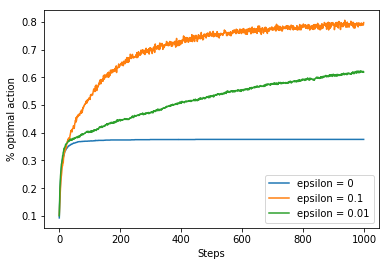

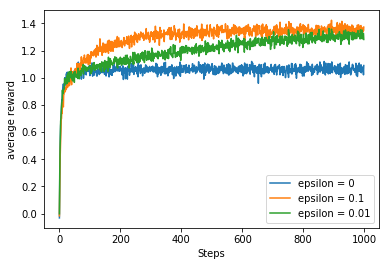

In [13]:
#figure2_1()
epsilonGreedy(2000, 1000)
#optimisticInitialValues(nBandits=2000, time=1000)
#ucb(2000, 1000)
#gradientBandit(2000, 1000)

# This will take somehow a long time
#figure2_6(2000, 1000)

plt.show()

### Exercise 2.5

Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. 

- Use a modified version of the 10-armed testbed in which all the $q_∗(a)$ start out equal and then take independent random walks (say by adding a normally distributed increment with mean zero and standard deviation 0.01 to all the $q_∗(a)$ on each step). 

- Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter, α = 0.1. Use ε = 0.1 and longer runs, say of 10,000 steps.

In [60]:
class Bandit:
    # @kArm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @initial: initial estimation for each action
    # @stepSize: constant step size for updating estimations
    # @sampleAverages: if True, use sample averages to update estimations instead of constant step size
    # @UCB: if not None, use UCB algorithm to select action
    # @gradient: if True, use gradient based bandit algorithm
    # @gradientBaseline: if True, use average reward as baseline for gradient based bandit algorithm
    def __init__(self, kArm=10, epsilon=0., initial=0., stepSize=0.1, sampleAverages=False, UCBParam=None,
                 gradient=False, gradientBaseline=False, trueReward=0.):
        self.k = kArm
        # Step size alpha
        self.stepSize = stepSize
        self.sampleAverages = sampleAverages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCBParam = UCBParam
        self.gradient = gradient
        self.gradientBaseline = gradientBaseline
        self.averageReward = 0
        self.trueReward = trueReward

        # real reward for each action
        self.qTrue = []

        # estimation for each action
        self.qEst = np.zeros(self.k)

        # # of chosen times for each action
        self.actionCount = []

        self.epsilon = epsilon

        # initialize real rewards with N(0,1) distribution and estimations with desired initial value
        # each step
        #random_value = np.random.randn()
        random_value = 0
        for i in range(0, self.k):
            self.qTrue.append(trueReward)
            self.qEst[i] = initial
            self.actionCount.append(0)

        self.bestAction = np.argmax(self.qTrue)

    # get an action for this bandit, explore or exploit?
    def getAction(self):
        # explore
        if self.epsilon > 0:
            if np.random.binomial(1, self.epsilon) == 1:
                np.random.shuffle(self.indices)
                return self.indices[0]

        # exploit
        if self.UCBParam is not None:
            UCBEst = self.qEst + \
                     self.UCBParam * np.sqrt(np.log(self.time + 1) / (np.asarray(self.actionCount) + 1))
            return np.argmax(UCBEst)
        if self.gradient:
            expEst = np.exp(self.qEst)
            self.actionProb = expEst / np.sum(expEst)
            return np.random.choice(self.indices, p=self.actionProb)
        return np.argmax(self.qEst)

    # take an action, update estimation for this action
    def takeAction(self, action):
        
        # take independent random walks (say by adding a normally distributed increment with mean zero 
        # and standard deviation 0.01 to ALL the q∗(a) on each step)
        for i in range(0, len(self.qTrue)):
            self.qTrue[i] += np.random.normal(loc=0, scale=0.01)
        
        # generate the reward under N(real reward, 1)
        reward = np.random.randn() + self.qTrue[action]
        self.time += 1
        self.averageReward = (self.time - 1.0) / self.time * self.averageReward + reward / self.time
        self.actionCount[action] += 1

        if self.gradient:
            oneHot = np.zeros(self.k)
            oneHot[action] = 1
            if self.gradientBaseline:
                baseline = self.averageReward
            else:
                baseline = 0
            self.qEst = self.qEst + self.stepSize * (reward - baseline) * (oneHot - self.actionProb)
        elif self.sampleAverages:
            # update estimation using icremental
            # This looks like the simple bandit algorithm
            # in section 2.4 incremental implementation
            self.qEst[action] += 1.0 / self.actionCount[action] * (reward - self.qEst[action])
        else:
            # update estimation with constant step size
            self.qEst[action] += self.stepSize * (reward - self.qEst[action])
        return reward

In [61]:
def banditSimulation(nBandits, time, bandits):
    bestActionCounts = [np.zeros(time, dtype='float') for _ in range(0, len(bandits))]
    averageRewards = [np.zeros(time, dtype='float') for _ in range(0, len(bandits))]
    for banditInd, bandit in enumerate(bandits):
        for i in range(0, nBandits):
            for t in range(0, time):
                action = bandit[i].getAction()
                reward = bandit[i].takeAction(action)
                averageRewards[banditInd][t] += reward
                if action == bandit[i].bestAction:
                    bestActionCounts[banditInd][t] += 1
        bestActionCounts[banditInd] /= nBandits
        averageRewards[banditInd] /= nBandits
    return bestActionCounts, averageRewards

In [62]:
def epsilonGreedy25(nBandits, time):
    epsilons = [0.1, 0.1]
    bandits = []
    for epsInd, eps in enumerate(epsilons):
        if epsInd == 0: # Use sample averages
            bandits.append([Bandit(epsilon=eps, sampleAverages=True) for _ in range(0, nBandits)])
        else: # Constant step size with alpha=0.1
            bandits.append([Bandit(epsilon=eps) for _ in range(0, nBandits)])
    bestActionCounts, averageRewards = banditSimulation(nBandits, time, bandits)
    global figureIndex
    plt.figure(figureIndex)
    figureIndex += 1
    for eps, counts in zip(epsilons, bestActionCounts):
        plt.plot(counts, label='epsilon = '+str(eps))
    plt.xlabel('Steps')
    plt.ylabel('% optimal action')
    plt.legend()
    plt.figure(figureIndex)
    figureIndex += 1
    for eps, rewards in zip(epsilons, averageRewards):
        plt.plot(rewards, label='epsilon = '+str(eps) + ' alpha = 0.1')
    plt.xlabel('Steps')
    plt.ylabel('average reward')
    plt.legend()

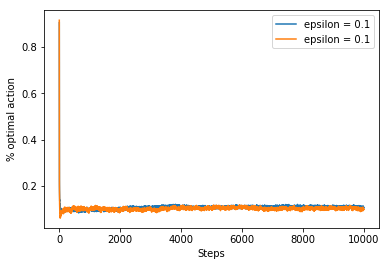

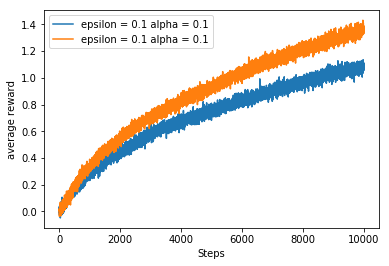

In [63]:
epsilonGreedy25(nBandits=2000, time=10000)
plt.show()

#### What do you observe in your experiments results of part b)? What made this problem different?

The graph shows that the average reward using the constant step size (the orange one) is higher than using the sample averages method (the blue one) if the agent do enough steps. In a nonstationary problem, using the sample averages is not an optimal solution because the true reward increases over the time, which means that there's not a limit for the true reward, with the sample averages, we only focus on averaging the total rewards of action $a$ at time $t$. However, with the constant step size method, with a large enought step size $\alpha$, we can actually get to the true reward faster than averaging the reward.




